# Helping classifier

Testing out idea: 

* Make a classifier, with train, test and val sets
* Maybe do some sort of fold in terms of validation 
* Train the classifier, and test on the validation set. 
* Make a new label --> Label == 1 if the classification was wrong --> want a classifier to detect data where the classification is likely wrong 
* Firstly run classification algorithm that detects if the classification will likely be wrong
* Run the second algorithm that actually classifies, and see if this is correct or not

Could maybe in the end filter out the testing samples where the algorithm thinks the classification will likely be wrong 

In [86]:
from sklearn.model_selection import GridSearchCV 
from sklearn.neighbors import KNeighborsClassifier
import sys
import os
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
module_path = os.path.abspath(os.path.join('..'))
sys.path.insert(1, module_path + '/src/')

import utility

# Loading a training, testing and validation set

20 % Testing
40 % Train
40 % Validation

The validation set is used as training set for the helping classifier 

1266


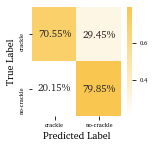

In [96]:
X, y =  utility.get_X_y('noDecomp', feature_type = 'all')

kwargs = dict(test_size=0.2, random_state=1)
X_train_og, X_test, y_train_og, y_test = train_test_split(X, y, **kwargs)
X_train, X_val, y_train, y_val = train_test_split(X_train_og, y_train_og, test_size=0.5, random_state = 1)


clf = KNeighborsClassifier(leaf_size=1, n_neighbors=1, p=1)
clf.fit(X_val, y_val) 
y_pred = clf.predict(X_train)

print(len(y_pred))
cm = confusion_matrix(y_pred, y_train)
utility.plot_cm(cm, 3)

Helper classifier is created. This classifier is supposed to classify if the new observation is likely to be missclassified. If True, then the observation is likely incorrectly classified 

In [82]:
new_X = X_train
new_y = pd.Series(np.hstack([y_pred != y_train]))

clf_2 = KNeighborsClassifier(leaf_size=1, n_neighbors=1, p=1)
clf_2.fit(new_X, new_y) 

KNeighborsClassifier(leaf_size=1, n_neighbors=1, p=1)

The resulting prediction without using the helping classifier

634


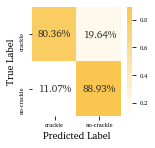

In [83]:
clf = KNeighborsClassifier(leaf_size=1, n_neighbors=1, p=1)
clf.fit(X_train_og, y_train_og) 

y_pred = clf.predict(X_test)
print(len(y_pred))
cm = confusion_matrix(y_pred, y_test)
utility.plot_cm(cm, 3)

Removing all samples that the helping classifier thinks will be classified incorrectly

In [84]:
y_pred_2 = clf_2.predict(X_test)
idx = len(y_pred_2) - 1
for c in reversed(y_pred_2):
    if c: 
        continue
    else:
        X_test = X_test.drop(X_test.index[idx])
        y_test = y_test.drop(y_test.index[idx])
    idx = idx - 1
y_pred = clf.predict(X_test)

Classification below is the result of using both the helper and the original classifier

153


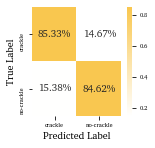

In [85]:
y_pred_1 = clf.predict(X_test)
print(len(y_pred_1))
cm = confusion_matrix(y_pred_1, y_test)
utility.plot_cm(cm, 3)

Summary of procedure: 

1. Split dataset into Train and Test ( 80 % and 20 %)
2. Split training set into 50 % validation and 50% train
3. Train a classifier on the remaining training set, and test on the remaining validation set
4. Create a new dataset where the label is == True if the classification done on the training set was wrong and == False if the classification done on the training set was correct. 
5. 

# Using 10 fold cross validation with logistic regression

634


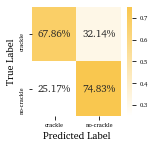

In [109]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning, FitFailedWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FitFailedWarning)


grid={"C":np.logspace(-10,3,19), "penalty":["l1","l2"]}
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train_og,y_train_og)
clf = logreg_cv.best_estimator_

y_pred = clf.predict(X_test)

print(len(y_pred))
cm = confusion_matrix(y_pred, y_test)
utility.plot_cm(cm, 3)

In [110]:
logreg_cv.fit(X_train,y_train)
clf = logreg_cv.best_estimator_
y_pred = clf.predict(X_val)


new_X = X_val
new_y = pd.Series(y_pred != y_val)


logreg_cv.fit(new_X,new_y)
clf_2 = logreg_cv.best_estimator_
y_pred_2 = clf_2.predict(X_test)
to_del = np.where(y_pred_2 == True)[0]

X_test = X_test.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

X_test_new = X_test[~X_test.index.isin(to_del)]
y_test_new = y_test[~y_test.index.isin(to_del)]

634


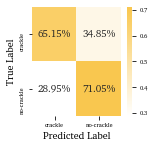

In [112]:
y_pred = clf.predict(X_test_new)

print(len(y_pred))
cm = confusion_matrix(y_pred, y_test_new)
utility.plot_cm(cm, 3)

# 10 fold cross validation using Random forest

634


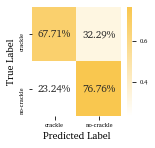

In [113]:
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train_og, y_train_og)
clf = CV_rfc.best_estimator_

y_pred = clf.predict(X_test)

print(len(y_pred))
cm = confusion_matrix(y_pred, y_test)
utility.plot_cm(cm, 3)

In [114]:
CV_rfc.fit(X_train,y_train)
clf = CV_rfc.best_estimator_
y_pred = clf.predict(X_val)


new_X = X_val
new_y = pd.Series(y_pred != y_val)

CV_rfc.fit(new_X,new_y)
clf = CV_rfc.best_estimator_
y_pred_2 = clf_2.predict(X_test)
to_del = np.where(y_pred_2 == True)[0]

X_test = X_test.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

X_test_new = X_test[~X_test.index.isin(to_del)]
y_test_new = y_test[~y_test.index.isin(to_del)]

y_pred = clf.predict(X_test_new)

print(len(y_pred))
cm = confusion_matrix(y_pred, y_test_new)
utility.plot_cm(cm, 3)

634


TypeError: '<' not supported between instances of 'str' and 'bool'

In [117]:
y_pred = clf.predict(X_test_new)

In [118]:
y_pred

array([False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,